*This notebook was created by Mykola Veremchuk (mykola.veremchuk@xfel.eu). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). July 2019.*

## Tutorial N3. Reflection from imperfect highly polished mirror.

In this tutorial we will focus on generating imperfect surfaces and reflection of the radiation fields from it.

In [1]:
from ocelot.optics.wave import * 
from ocelot.gui.dfl_plot import *

# setup logger level (it is not necessary)
from ocelot.optics.wave import _logger
import logging
_logger.setLevel(logging.ERROR)

from ocelot.gui.dfl_plot import _logger
_logger.setLevel(logging.ERROR)

initializing ocelot...


In [2]:
# Activate interactive matplolib in notebook
import matplotlib
%matplotlib inline
# Setup figure white background 
matplotlib.rcParams["figure.facecolor"] = (1,1,1,1)
# Setup figure size
matplotlib.rcParams['figure.figsize'] = [10, 10]


Also we can found the main parameters of the chicane with ```chicane_RTU(yoke_len, dip_dist, r, type)```
### Contents
1. [Generating highly polished mirror](#mirror)
2. [Reflection radiation field from imperfect mirror](#reflect) 


<a id='mirror'></a>
## Highly polished mirror 
Generation of mirror surfaces is based on
[W.Q. Hua, F.G. Bian, Y.M. He, W.H. Lin, L. Song, J. Wang, N. Zhao, 
Using the power spectral density method to characterize and evaluate the X-ray mirrors surfaces (2013)](http://scripts.iucr.org/cgi-bin/paper?S1600577519002509)

We uses 1D surfaces because the angle of incidence with respect to the surface is really small in in FEL beamlines.

The height errors along the axis

\begin{equation}
h\prime (x) = \frac{M}{L} F^{-1} \Big( \sqrt{L * PSD(k)} * e^{j\phi(k)} \Big)
\end{equation}

where

* $PSD(k)$ : power spectral density of the surface 
* $M$ : number of points (pixels) on the surface
* $L$ : length of the surface
* $\phi(k)$ : randomly valued phase map ($-\pi < \phi(k) < \pi$)
* $k$ : wavevector

Reflection function is based on
[S. Serkez Design and Optimization of the Grating Monochromator for Soft X-Ray Self-Seeding FELs](https://www.researchgate.net/publication/311516090_Design_and_Optimization_of_the_Grating_Monochromator_for_Soft_X-Ray_Self-Seeding_FELs)

PSD can be calculated using formula

\begin{equation}
PSD(k) = \frac{1}{L} *  \int_{-L/2}^{L/2} h(x) e^{-j2\pi kx} dx
\end{equation}

PSD of highly polished mirrors are line in loglog scale:

\begin{equation}
PSD(k) = b * k - \alpha
\end{equation}

where
* $b$ : the slope of the power spectrum on a log-log scale 
* $\alpha$ : determined by the fractal dimension D satisfying 1 < D < 2, D = (5 - $\alpha$) / 2


To generate HeightProfile using formulas from above there is the function:

```hprofile = generate_1d_profile(hrms, length=0.1, points_number=1000)```

* ```hrms```: [m] height errors root mean square
* ```length```: [m] length of the surface
* ```points_number```: number of points (pixels) at the surface

Optional parameters:

###### It is not obvious from our explanation what ```wavevector_cutoff``` is responsible for. There will be example of it usage.
* ```wavevector_cutoff```: [1/m] point on k axis for cut off small wavevectors (large wave lengths) in the PSD (with default value 0 effects on nothing)
* ```psd```: [m^3] 1d array; power spectral density of surface (if not specified, will be generated) (if specified, must have shape = (points_number // 2 + 1, ), otherwise it will be cut to appropriate shape)
* ```seed```: seed for np.random.seed() to allow reproducibility
it returns ocelot.optics.HeightProfile object, which can describe a geometry of not only the mirror surface 

In [3]:
hprofile1 = generate_1d_profile(hrms=1e-9, length=0.03, points_number=1111, seed=666)


We can easy plot HeightProfile using function
```plot_1d_hprofile()```


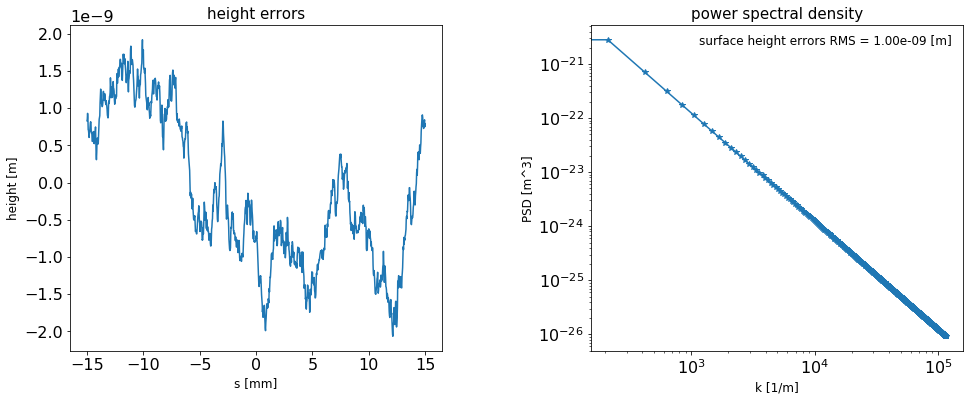

In [4]:
plot_1d_hprofile(hprofile1, fig_name='mirror1 height profile and PSD')


In some papers was described PSD which has plateau on the beginning and than it goes like linear function in loglog scale
That is why we introduced ```wavevector_cutoff``` parameter. It defines the end of the plateau.


In [5]:
hprofile2 = generate_1d_profile(hrms=1e-9, length=0.001, points_number=1000, wavevector_cutoff=100000)


HeightProfile with ```wavevector_cutoff = 100000```


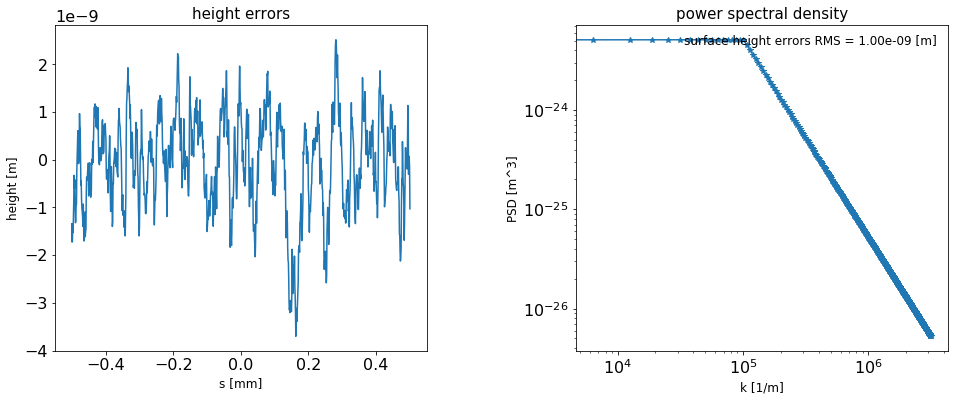

In [6]:
plot_1d_hprofile(hprofile2, fig_name='mirror2 height profile and PSD')



<a id='reflect'></a>
## Reflection radiation field from imperfect mirror 

Reflection function is based on
[S. Serkez, Design and Optimization of the Grating Monochromator for Soft X-Ray Self-Seeding FELs (2015), page 42-44](https://www.researchgate.net/publication/311516090_Design_and_Optimization_of_the_Grating_Monochromator_for_Soft_X-Ray_Self-Seeding_FELs)

It is easy to demonstrate that an error $\delta h$ on the optical surface will perturb the wavefront of a phase 
$\delta \phi$, according to

\begin{equation}
\delta \phi = \frac{4 \pi \delta h}{\lambda} \sin \theta_i
\end{equation}

where
* $\theta_i$ : the angle of incidence with respect to the surface


To reflect radiation field (ocelot.optics.wave.RadiationField) off the mirror (ocelot.optics.wave.HeightProfile) there is the function:

```dfl_reflect_surface(dfl, angle, height_profile=None, axis='x')```

* ```dfl```: RadiationField object from ocelot.optics.wave
* ```angle```: [rad] angle of incidence with respect to the surface
* ```height_profile```: HeightProfile object of the reflecting surface (if not specified, will be generated using ```hrms```)
* ```axis```: direction along which reflection takes place

Optional parameters:

* ```hrms```: [m] height root mean square of reflecting surface (if ```height_profile``` is not specified, ```hrms``` will be used to generate height_profile internally)
* ```seed```: seed for np.random.seed() to allow reproducibility
* ```return_height_profile```: boolean type variable; if it equals True the function will return height_profile which was used in reflection


In [7]:
# generating gaussian RadiationField
dfl1 = generate_gaussian_dfl(1e-9, (1000, 1000, 1))

radiation before mirror1

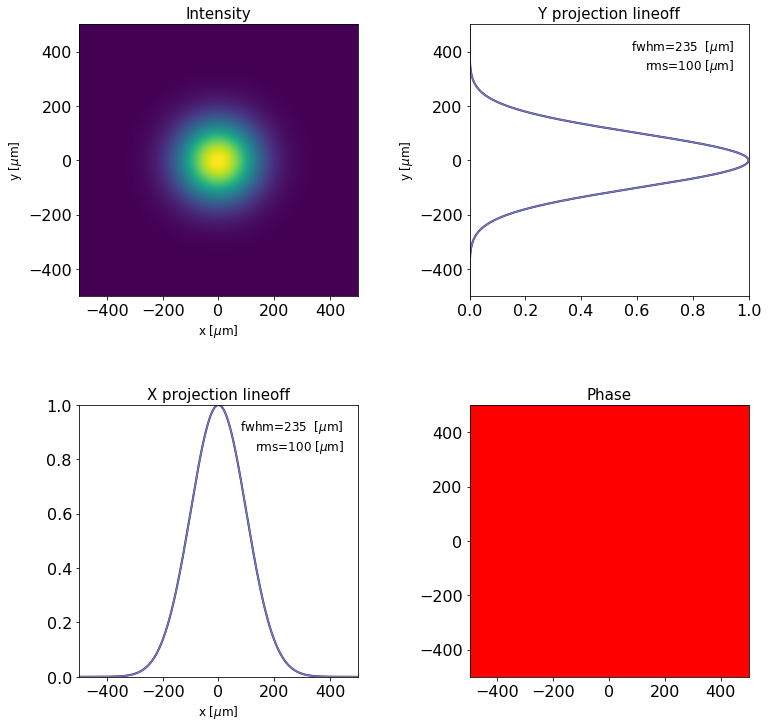

In [8]:
plot_dfl(dfl1, phase=1, fig_name='radiation before mirror1')


In [9]:
# reflecting generated RadiationField from the imperfect mirror
dfl_reflect_surface(dfl1, angle=np.pi * 2 / 180, height_profile=hprofile1, axis='x')

radiation after reflection from mirror1 (x direction), 10 meters propagation and another reflection from mirror2 (y direction)
radiation after reflection from mirror1

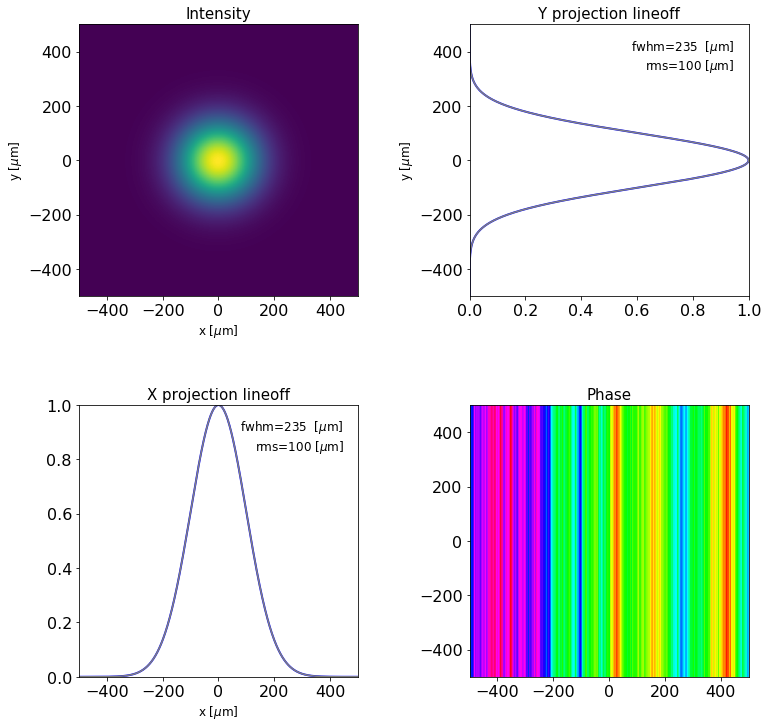

In [10]:
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror1')


In [11]:
# propagating RadiationField for 10 meters
dfl1.prop(z=10)

radiation after reflection from mirror1 and propagation

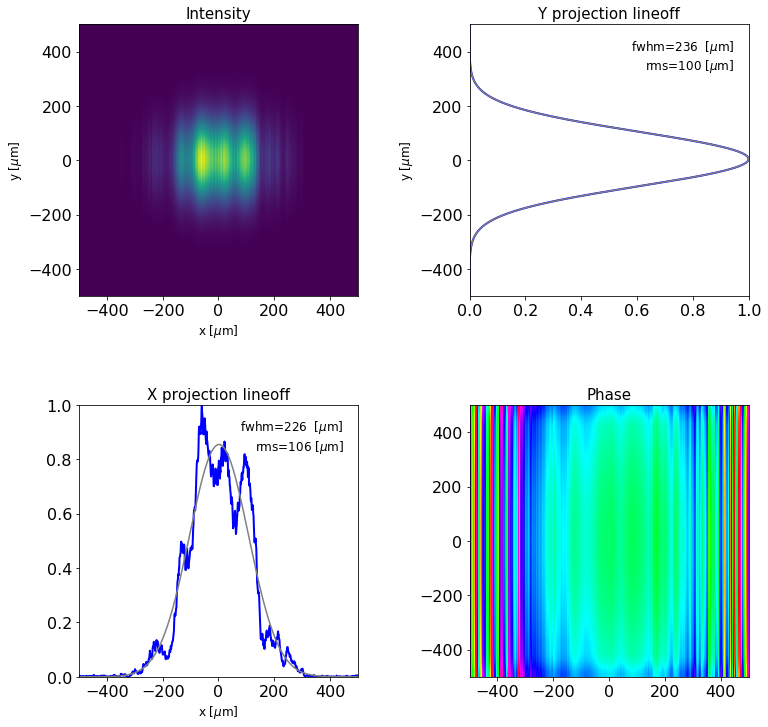

In [12]:
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror1 and propagation')


In [13]:
# reflecting generated RadiationField from the imperfect mirror along another direction
# also ```height_profile``` is not specified, so it will be generated internally
hprofile3 = dfl_reflect_surface(dfl1, angle=np.pi * 2 / 180, hrms=1e-9, axis='y', return_height_profile=1, seed=13)

internally generated mirror3 height profile and PSD

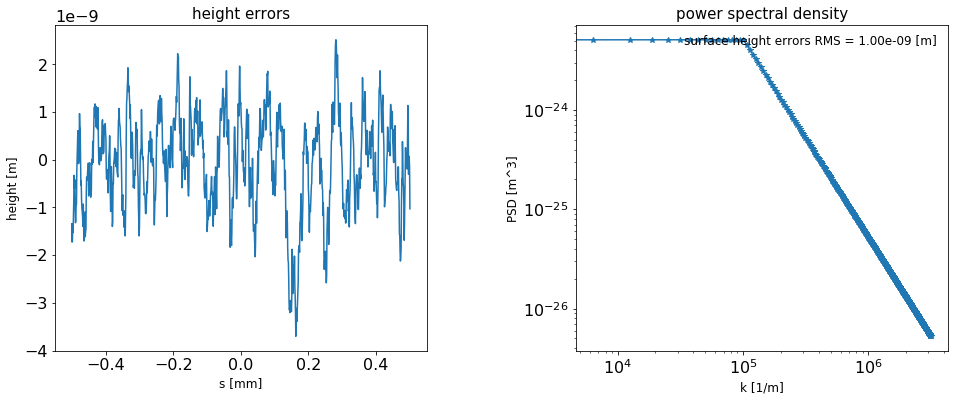

In [14]:
plot_1d_hprofile(hprofile2, fig_name='internally generated mirror3 height profile and PSD') 

radiation after reflection from mirror1 (x direction), 10 meters propagation and another reflection from mirror3 (y direction)

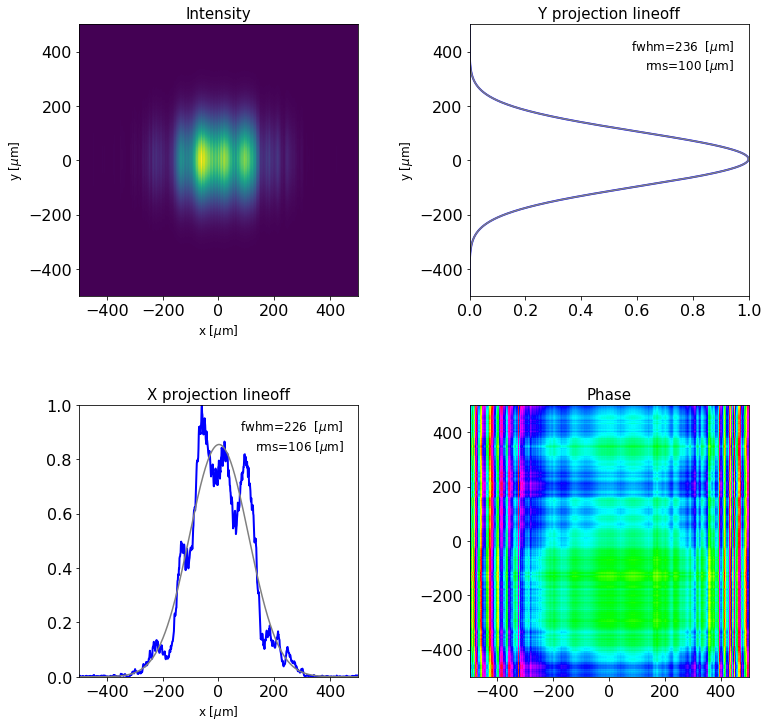

In [15]:
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror3')


In [16]:
# propagating RadiationField for 10 meters
dfl1.prop(z=10)

radiation after reflection from mirror1 (x direction), 10 meters propagation, reflection from mirror3 (y direction) and 10 meters propagation

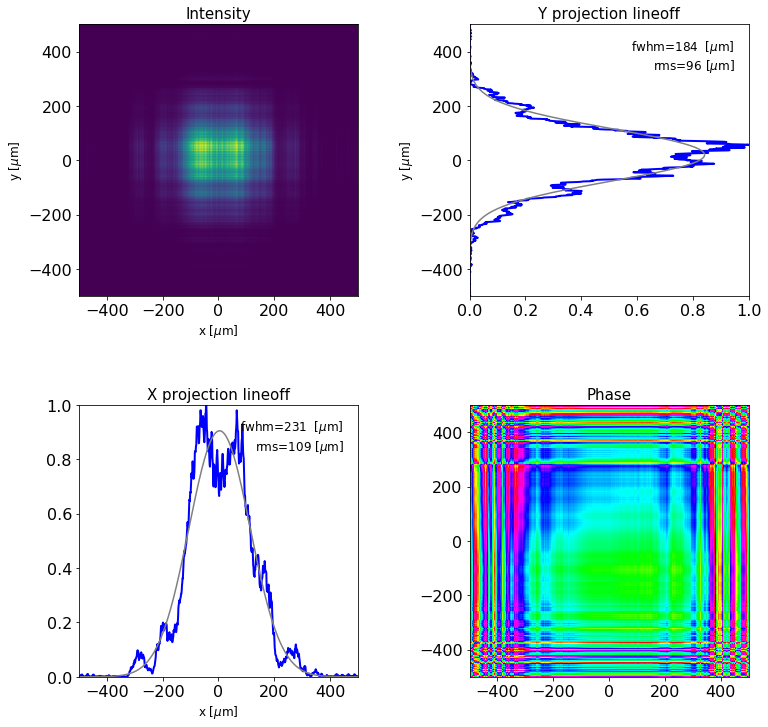

In [17]:
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror3 and propagation')
